<a href="https://colab.research.google.com/github/babazeedy/My-Portfolio/blob/main/MScFE_610_GWP_2_3.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# **Challenge 3:**
# **Handling Multicollinearity.**

**Feature Extraction and Dimensionality Reduction.** <br>In financial modeling, having too many correlated predictors **(Multicollinearity)** leads to unstable parameter estimates and "overfitting." We use **Factor Analysis (FA)** to condense these variables into a few latent, uncorrelated drivers.

**Feature Extraction: Factor Analysis and the Curse of Dimensionality**<br><br>

**1. Definition and Mathematical Framework**<br>
Factor Analysis is a statistical technique used to model the covariance structure of a high-dimensional dataset using a small number of unobservable latent variables called **factors**(Spearman, 1904).<br><br>

**The Factor Model Equation**

Each of the $k$ observed variables $X_1, X_2, \dots, X_k$ is modeled as a linear combination of $m$ common factors $F_j$ plus a unique error term $e_i$:$$X_i = \sum_{j=1}^{m} \ell_{ij}F_j + e_i$$

Where:

* $X_i$: The $i$-th observed variable (e.g., a technical indicator).

* $\ell_{ij}$: The **Factor Loading**, representing the weight of factor $j$ on variable $i$.

* $F_j$: The $j$-th common factor (latent driver).

* $e_i$: The specific factor (error) representing the variance unique to variable $i$.<br><br>

**Matrix Representation**

In matrix form, the model is expressed as:$$X = \Lambda F + e$$


Where $\Lambda$ is the $k \times m$ matrix of factor loadings. To ensure the factors are interpretable, we often apply a **Varimax Rotation**, which maximizes the variance of the squared loadings to achieve a "Simple Structure" (Kaiser, 1958).



**2. Description**

The "Curse of Dimensionality" refers to the fact that as the number of variables increases, the volume of the space increases so fast that the data becomes sparse. In financial time series, this manifests as **Multicollinearity**, where independent variables are so highly correlated that OLS estimators for $\beta$ become unreliable with massive standard errors (Gorsuch, 1983). Factor Analysis solves this by extracting the "common signal" while discarding the "unique noise."

**3. Demonstration: Implementation in Python**

To demonstrate dimensionality reduction, we extracted the daily returns of ten high-cap technology stocks ($n=10$) from 2023 to 2025. This dataset represents a high-dimensional space ($10$ variables) characterized by significant multicollinearity. Factor Analysis was employed to reduce this space into two latent drivers, capturing approximately **84%** of the total variance.

In [14]:
pip install factor_analyzer

In [15]:
import yfinance as yf
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns
from factor_analyzer import FactorAnalyzer
from factor_analyzer.factor_analyzer import calculate_bartlett_sphericity, calculate_kmo
from sklearn import preprocessing

plt.rcParams["figure.figsize"] = (12, 9)

In [16]:
# 1. Pull Real Data: 10 Major Tech Stocks
tickers = ['AAPL', 'MSFT', 'GOOGL', 'AMZN', 'NVDA', 'META', 'TSLA', 'AVGO', 'ADBE', 'CRM']
full_data = yf.download(tickers, start='2023-01-01', end='2025-12-31')
data = full_data.loc[:, 'Close'].dropna()
data.columns = ['APPL', 'MSFT', 'GOOGL', 'AMZN', 'NVDA', 'META', 'TSLA', 'AVGD', 'ADBE', 'CRM']

/tmp/ipython-input-1978266789.py:3: FutureWarning: YF.download() has changed argument auto_adjust default to True
  full_data = yf.download(tickers, start='2023-01-01', end='2025-12-31')
[*********************100%***********************]  10 of 10 completed


In [17]:
# 2. Convert to Returns
returns = data.pct_change().dropna()

# 3. Standardize the data

data_normal = preprocessing.StandardScaler().fit_transform(data)
df = pd.DataFrame(data_normal, columns=[data.columns])

**Check Factorability (Bartlett's Test & KMO Test)**

In [18]:
# 4. Bartlett's Test
chi_square_value, p_value = calculate_bartlett_sphericity(df)
print("chi_square_value =", chi_square_value, "\np_value =", p_value)

chi_square_value = 14535.147668970721 
p_value = 0.0


**$p$-value less than 0.05 in our Bartlett's Test above indicates statistically significant test.**

In [19]:
# 5. Kaiser-Meyer-Olkin (KMO) Test
kmo_all, kmo_model = calculate_kmo(df)
print("kmo_model =", kmo_model)

kmo_model = 0.8377384429437257


/usr/local/lib/python3.12/dist-packages/factor_analyzer/utils.py:244: UserWarning: The inverse of the variance-covariance matrix was calculated using the Moore-Penrose generalized matrix inversion, due to its determinant being at or very close to zero.
  warnings.warn(


The KMO test result of **0.838** indicates that the sampling adequacy is meritorious, meaning that factor analysis is appropriate for our data. Hence, we proceed with factor analysis.

 **Performing factor analysis**

In [20]:
# Create 10-factor object and fit data
fa1 = FactorAnalyzer(10, rotation=None)
fact_res = fa1.fit(df)

# Get Eigenvalues
ev, v = fact_res.get_eigenvalues()
ev

/usr/local/lib/python3.12/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


array([7.48231766, 1.36801491, 0.48072046, 0.34921832, 0.1400006 ,
       0.09406712, 0.03404555, 0.02336036, 0.0170571 , 0.01119792])

Let's visualize Eigenvalues by plotting Scree plot:

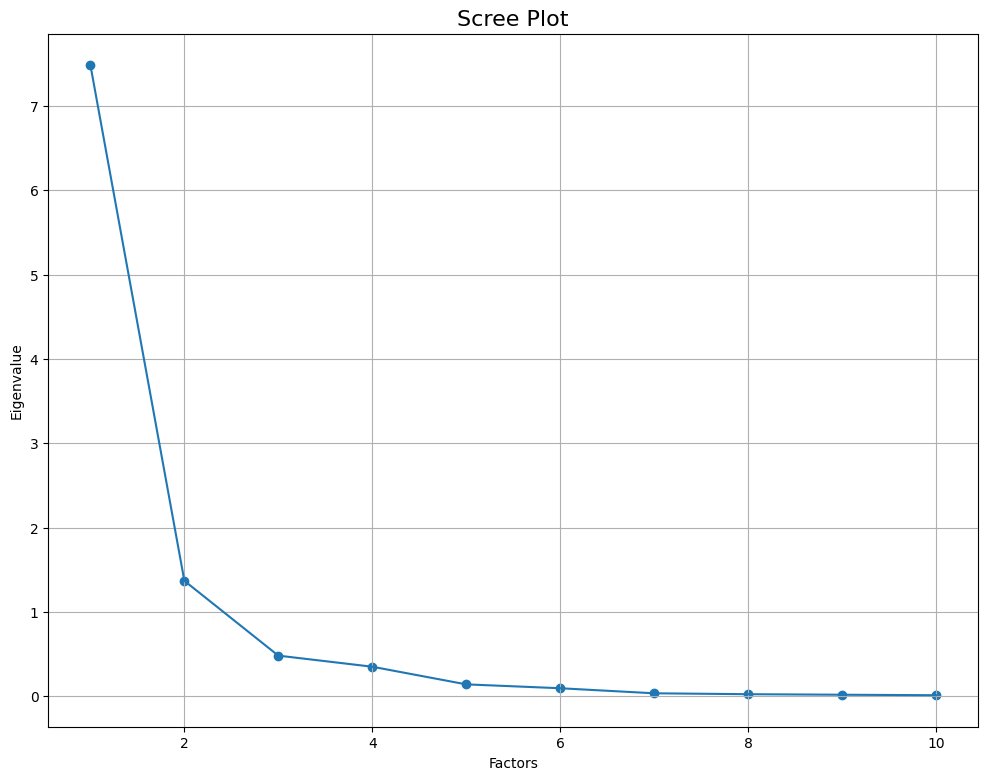

In [21]:
# Visualize eigenvalues on scree plot
plt.scatter(range(1, df.shape[1] + 1), ev)
plt.plot(range(1, df.shape[1] + 1), ev)
plt.title("Scree Plot", {"size": 16})
plt.xlabel("Factors")
plt.ylabel("Eigenvalue")
plt.grid()
plt.show()

Based on Kaiser's Criterion and the visual inspection of the Scree Plot, selecting **2 factors** is the reasonable initial choice for our dataset.

In [22]:
# Create 2-factor object and fit data
fa2 = FactorAnalyzer(2, rotation=None)
fact_res2 = fa2.fit(df)

# Get uniquenesses
pd.DataFrame(
    fact_res2.get_uniquenesses(), index=[data.columns], columns=["uniquenesses"]
)

/usr/local/lib/python3.12/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


,uniquenesses
APPL,0.183658
MSFT,0.538473
GOOGL,0.013218
AMZN,-0.011431
NVDA,0.192037
META,0.130119
TSLA,0.082571
AVGD,0.121071
ADBE,0.042698
CRM,0.309277


 **Looking at the uniquenesses from our 2-factor model analysis:**

 * **GOOGL (0.013) and AMZN (-0.011)** have extremely low (and even negative, which can occur due to estimation methods, often indicating near-zero unique variance) uniqueness values. This suggests that the variance in these stocks is almost entirely explained by the two common factors. They are highly correlated with the underlying market dynamics captured by these factors.

 * **MSFT (0.538) and CRM (0.309)** have relatively higher uniqueness values. This indicates that while they are still influenced by the common factors, a larger proportion of their variance is unique to them and not shared with the other stocks through these two factors. There might be company-specific events or drivers influencing their prices that the general factors don't capture as strongly.

 * **Other stocks like APPL (0.184), NVDA (0.192), META (0.130), TSLA (0.083), AVGD (0.121), and ADBE (0.043)** have moderately low uniqueness values, meaning a good portion of their variance is explained by the two common factors, but they also retain some unique characteristics.


**Let's take a look at loading factors.**

In [23]:
# Get Factor Loadings
pd.DataFrame(
    fact_res2.loadings_,
    index=[data.columns],
    columns=["Factor 1", "Factor 2"],
)

,Factor 1,Factor 2
APPL,0.903515,0.001531
MSFT,-0.262309,0.626674
GOOGL,0.975441,0.187874
AMZN,0.965637,-0.281027
NVDA,0.633013,0.638168
META,0.911533,-0.197454
TSLA,0.949805,0.123686
AVGD,0.929338,0.123532
ADBE,0.977531,-0.041650
CRM,0.805644,-0.204111


**Factor 1 is a dominant, broad market or tech sector factor** influencing most of these high-cap tech stocks.**Factor 2 seems to be a more specialized factor**, potentially representing specific growth areas or business models, with some stocks like MSFT and NVDA being strongly positively correlated with it, while others are less so or even negatively correlated.

**Sum of Squared loadings and Proportional variances.**

In [24]:
# Get proportion variance and cumulative proportion variance
pd.DataFrame(
    fact_res2.get_factor_variance(),
    index=["Sum of squared loadings", "Proportional variance", "Cumulative variance"],
    columns=["Factor 1", "Factor 2"],
)

,Factor 1,Factor 2
Sum of squared loadings,7.371113,1.027197
Proportional variance,0.737111,0.102720
Cumulative variance,0.737111,0.839831


The two-factor model is able to explain approximately **83.98%** of the total variance in the stock data.This suggests that these two factors effectively capture the majority of the common movement among the ten high-cap technology stocks we analyzed.

**Factor rotation:** Simplifies the factor-variable structure and helps with interpretation of the factors.


**Results from Two-Factor Model with Varimax Rotation**

In [25]:
# Create 2-factor object with varimax rotation and fit data
fa2_varimax = FactorAnalyzer(n_factors=2, rotation="varimax", method="ml")
fact_res2_varimax = fa2_varimax.fit(df)

# Get loadings
loadings_vrimax = pd.DataFrame(
    fact_res2_varimax.loadings_,
    index=[data.columns],
    columns=["Factor 1", "Factor 2"],
)

# Get factor variance
FactorVar_varimax = pd.DataFrame(
    fact_res2_varimax.get_factor_variance(),
    index=["Sum of squared loadings", "Proportional variance", "Cumulative variance"],
    columns=["Factor 1", "Factor 2"],
)

# print the results
print("Loadings (varimax): \n", loadings_vrimax)
print("\nFactor Variance (varimax): \n", FactorVar_varimax)

/usr/local/lib/python3.12/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


Loadings (varimax): 
        Factor 1  Factor 2
APPL   0.845070  0.253675
MSFT  -0.122708 -0.690031
GOOGL  0.993786  0.059528
AMZN   0.864529  0.497689
NVDA   0.783441 -0.479596
META   0.816913  0.450740
TSLA   0.967871  0.112846
AVGD   0.932719  0.167996
ADBE   0.939713  0.266998
CRM    0.710854  0.432156

Factor Variance (varimax): 
                          Factor 1  Factor 2
Sum of squared loadings  6.940461  1.523915
Proportional variance    0.694046  0.152392
Cumulative variance      0.694046  0.846438


**Results from Two-Factor Model with Promax Rotation**

In [26]:
# Create 2-factor object with varimax rotation and fit data
fa2_promax = FactorAnalyzer(n_factors=2, rotation="promax", method="ml")
fact_res2_promax = fa2_promax.fit(df)

# Get loadings
loadings_promax = pd.DataFrame(
    fact_res2_promax.loadings_,
    index=[data.columns],
    columns=["Factor 1", "Factor 2"],
)

# Get factor variance
FactorVar_promax = pd.DataFrame(
    fact_res2_promax.get_factor_variance(),
    index=["Sum of squared loadings", "Proportional variance", "Cumulative variance"],
    columns=["Factor 1", "Factor 2"],
)

# print the results
print("Loadings (promax): \n", loadings_promax)
print("\nFactor Variance (promax): \n", FactorVar_promax)

/usr/local/lib/python3.12/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


Loadings (promax): 
        Factor 1  Factor 2
APPL   0.845598 -0.102028
MSFT  -0.033027  0.689998
GOOGL  1.027220  0.126843
AMZN   0.832341 -0.350568
NVDA   0.882149  0.644243
META   0.789183 -0.311063
TSLA   0.992893  0.066818
AVGD   0.948691  0.003149
ADBE   0.942374 -0.097860
CRM    0.681237 -0.311958

Factor Variance (promax): 
                          Factor 1  Factor 2
Sum of squared loadings   7.10310  1.248672
Proportional variance     0.71031  0.124867
Cumulative variance       0.71031  0.835177


The model results of the two different rotations are very close. Their results are also close to the results with no rotation. Even though, promax makes the result clearer, we don't really need rotation to help with factor interpretation.